In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import os.path
import glob
import math as m

In [2]:
def read_points(obj_file='obj_points.p', img_file='img_points.p', show=False, rewrite=False):

    if os.path.isfile(obj_file):
        obj_points = pickle.load(open(obj_file, 'rb'))

    if os.path.isfile(img_file):
        img_points = pickle.load(open(img_file, 'rb'))

    if rewrite:
        obj_points = []
        img_points = []
        images = glob.glob('./camera_cal/calibration*.jpg')
        obj_p = np.zeros((6 * 9, 3), np.float32)
        obj_p[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        for f_name in images:
            img = cv2.imread(f_name)
            # grayscale image
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            if ret == True:
                img_points.append(corners)
                obj_points.append(obj_p)
                # Draw and display the corners
                if show:
                    cv2.drawChessboardCorners(img, (9, 6), corners, ret)
                    plt.imshow(img)
        pickle.dump(obj_points, open(obj_file, "wb"))
        pickle.dump(img_points, open(img_file, "wb"))

    return obj_points, img_points


def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def perspective_tr(img, src, dst, img_size):
    t_m = cv2.getPerspectiveTransform(src, dst)
    tr_img = cv2.warpPerspective(img, t_m, img_size, flags=cv2.INTER_LINEAR)
    inv_m = cv2.getPerspectiveTransform(dst, src)
    return tr_img, t_m, inv_m


def score_pixels(img) -> np.ndarray:
        """
        Takes a road image and returns an image where pixel intensity maps to likelihood of it being part of the lane.
 
        Each pixel gets its own score, stored as pixel intensity. An intensity of zero means it is not from the lane,
        and a higher score means higher confidence of being from the lane.
 
        :param img: an image of a road, typically from an overhead perspective.
        :return: The score image.
        """
        # Settings to run thresholding operations on
        settings = [{'name': 'lab_b', 'cspace': 'LAB', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150},
                    {'name': 'value', 'cspace': 'HSV', 'channel': 2, 'clipLimit': 6.0, 'threshold': 220},
                    {'name': 'lightness', 'cspace': 'HLS', 'channel': 1, 'clipLimit': 2.0, 'threshold': 210}]
 
        # Perform binary thresholding according to each setting and combine them into one image.
        scores = np.zeros(img.shape[0:2]).astype('uint8')
        for params in settings:
            # Change color space
            color_t = getattr(cv2, 'COLOR_RGB2{}'.format(params['cspace']))
            gray = cv2.cvtColor(img, color_t)[:, :, params['channel']]
 
            # Normalize regions of the image using CLAHE
            clahe = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8, 8))
            norm_img = clahe.apply(gray)
 
            # Threshold to binary
            ret, binary = cv2.threshold(norm_img, params['threshold'], 1, cv2.THRESH_BINARY)
 
            scores += binary
    
         # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1
        
        scores += sxbinary
        
        combined_binary = np.zeros_like(scores)
        combined_binary[scores > 1] = 1
        
#         return cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)
        return combined_binary

def lane_lines(binary_warped, visualise=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    if visualise:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualise:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    l, r, d, la, ra = get_curvature(leftx, lefty, rightx, righty, binary_warped)
    
    if visualise:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fit, right_fit, l, r, d, la, ra, out_img
    else:
        return left_fit, right_fit, l, r, d, la, ra
    

def lane_lines2(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    l, r, d, la, ra = get_curvature(leftx, lefty, rightx, righty, binary_warped)
   
    return left_fit, right_fit, l, r, d, la, ra

def fit_lanes(warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def get_curvature(leftx, lefty, rightx, righty, binary_warped):
    image_size = binary_warped.shape
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    #Calculate angle of 
    def angle(value):
        return m.atan(value)*180/m.pi
    
    left_agnle = angle(2 * left_fit_cr[0] * scene_height + left_fit_cr[1])
    right_angle = angle(2 * right_fit_cr[0] * scene_height + right_fit_cr[1])
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation, left_agnle, right_angle

def draw(warped, undist, Minv, left_fit, right_fit, l, r, d, la, ra):
    #Draw lanes on scene   
    left_fitx, right_fitx, ploty = fit_lanes(warped, left_fit, right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    #TODO: add left_r, right_r, deviation
    curvature_text = "Curvature: Left = " + str(np.round(l, 2)) + ", Right = " + str(np.round(r, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(d)  
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
    angle_text = "Angle: Left = " + str(np.round(la, 2)) + ", Right = " + str(np.round(ra, 2)) 
    cv2.putText(result, angle_text, (30, 120), font, 1, (0,255,0), 2)
    return result

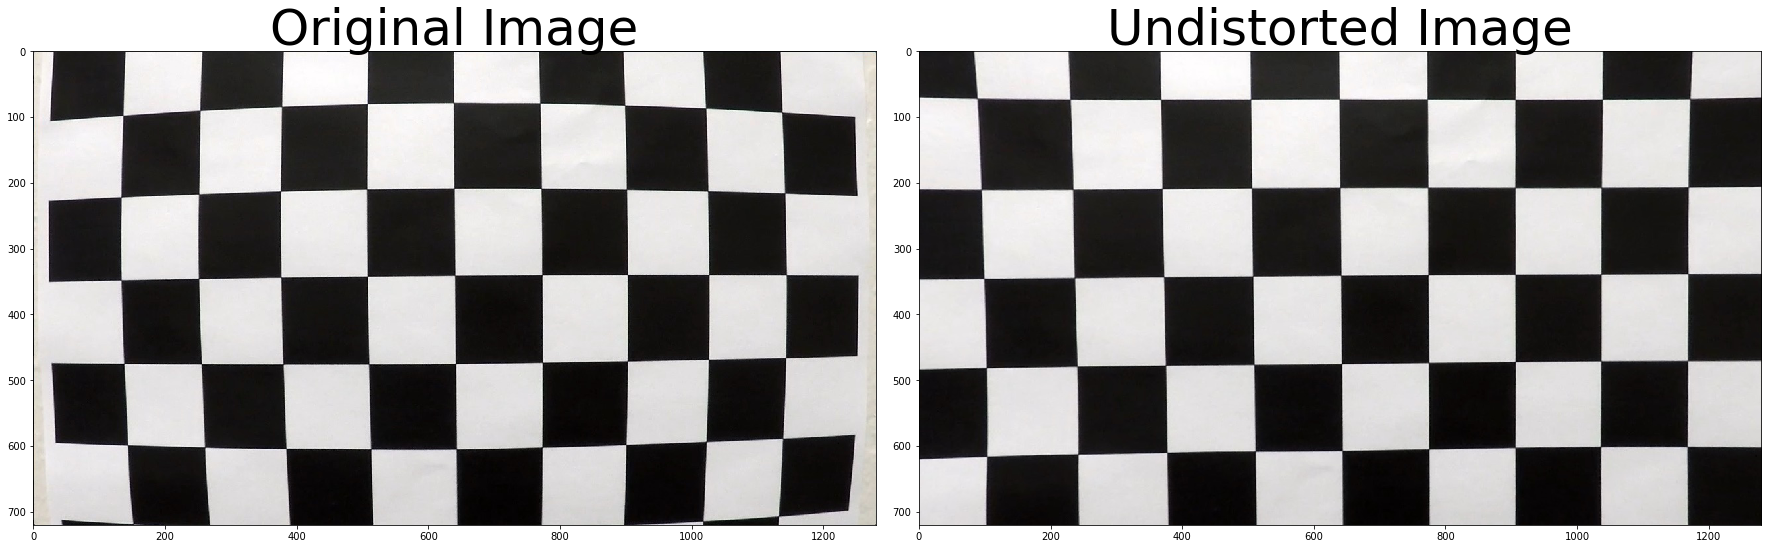

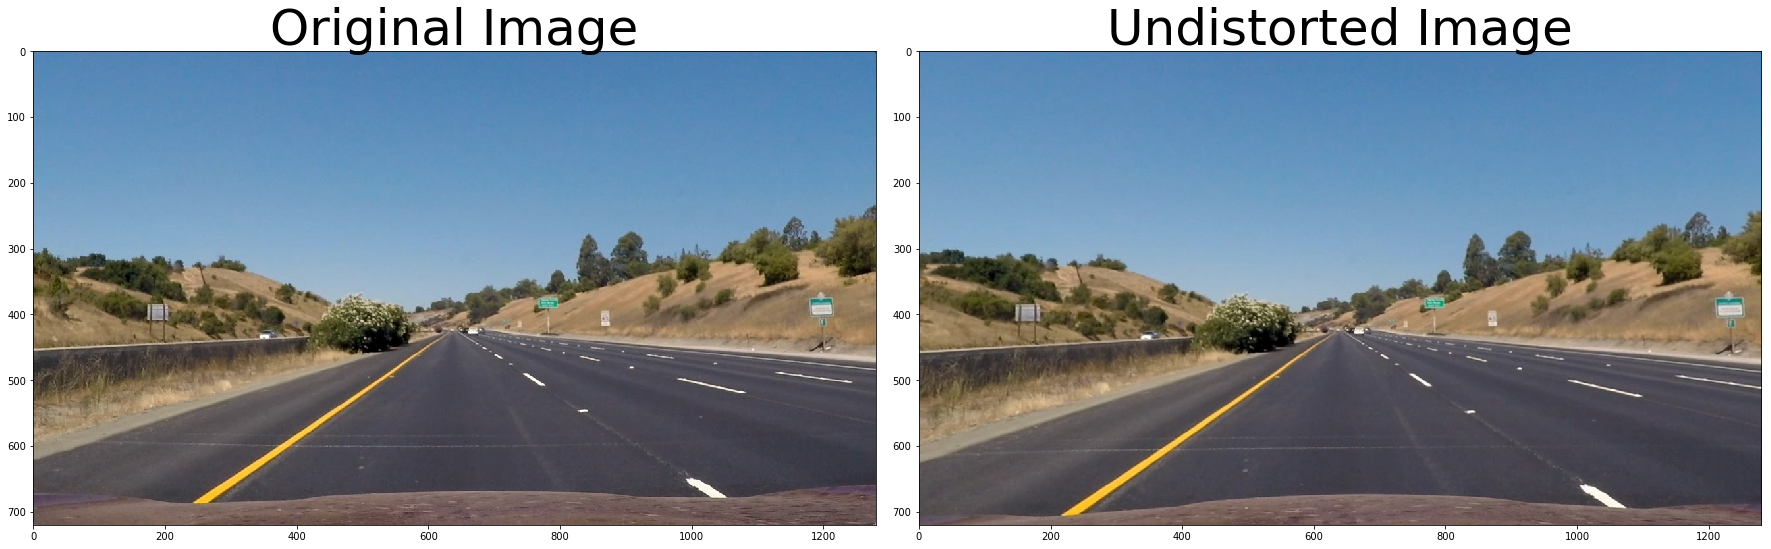

In [19]:
def show_und(img, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

%matplotlib inline
obj_points, img_points = read_points(rewrite=False, show=False)
# Show train result
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)
# Show test result
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)

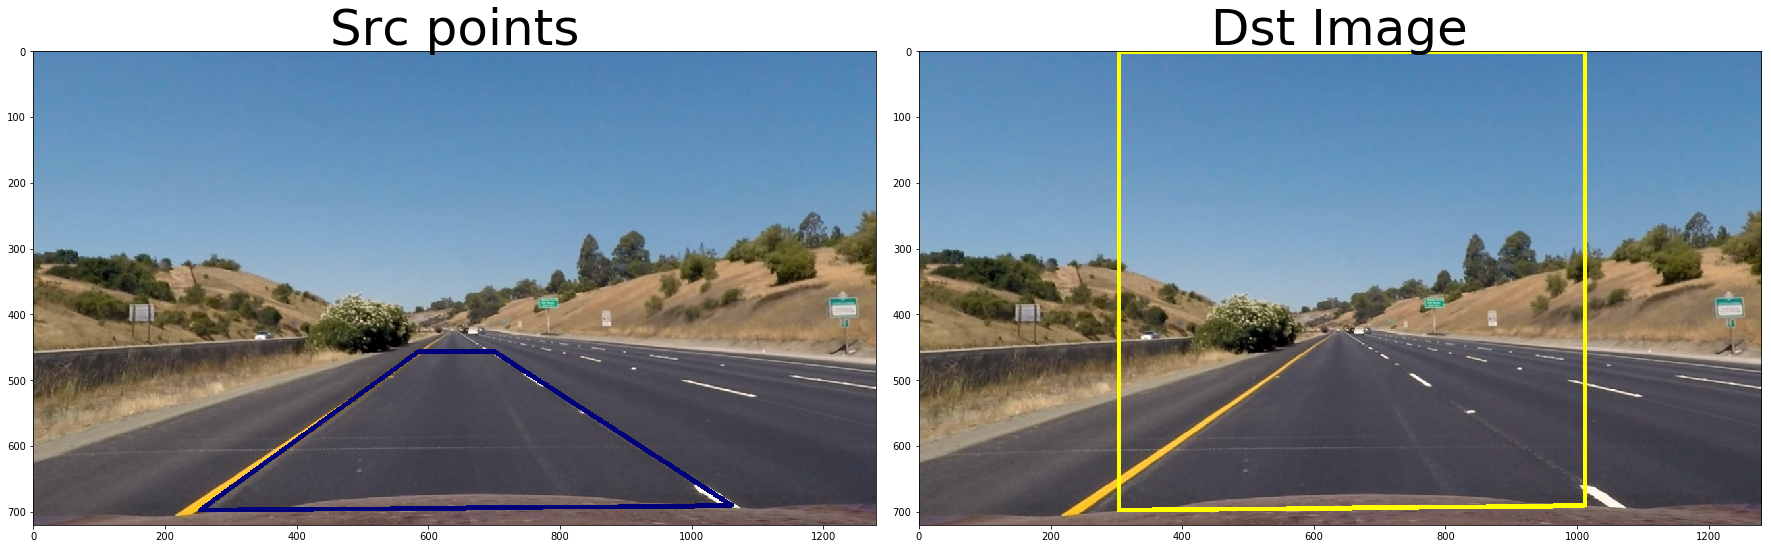

In [20]:
img = undistorted

w = img.shape[1]
h = img.shape[0]

src_img = img.copy()
dst_img = img.copy()

corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
cv2.polylines(src_img, np.int32([src]), True, (0, 0, 122), thickness=5)
cv2.polylines(dst_img, np.int32([dst]), True, (255, 255, 0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Src points', fontsize=50)
ax2.imshow(dst_img)
ax2.set_title('Dst Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

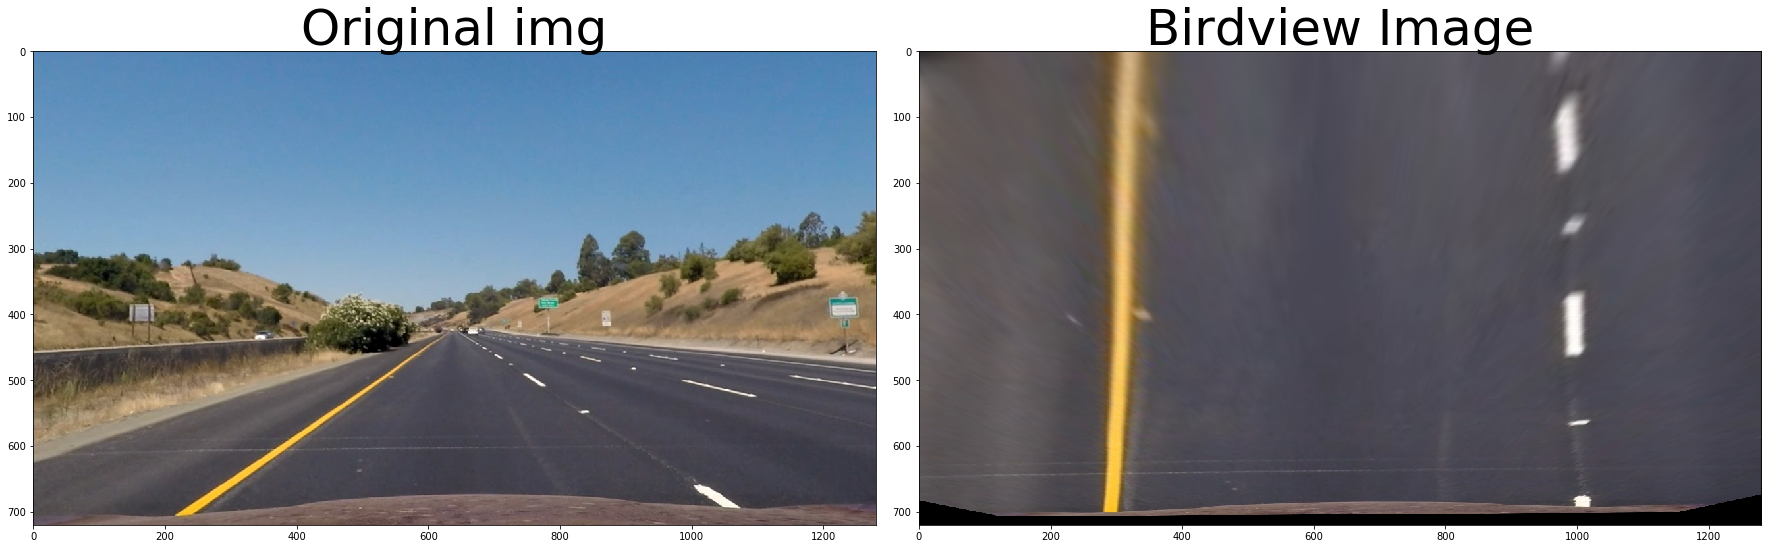

In [21]:
tr_img, t_m, inv_m = perspective_tr(img, src, dst, (img.shape[1], img.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original img', fontsize=50)
ax2.imshow(tr_img)
ax2.set_title('Birdview Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

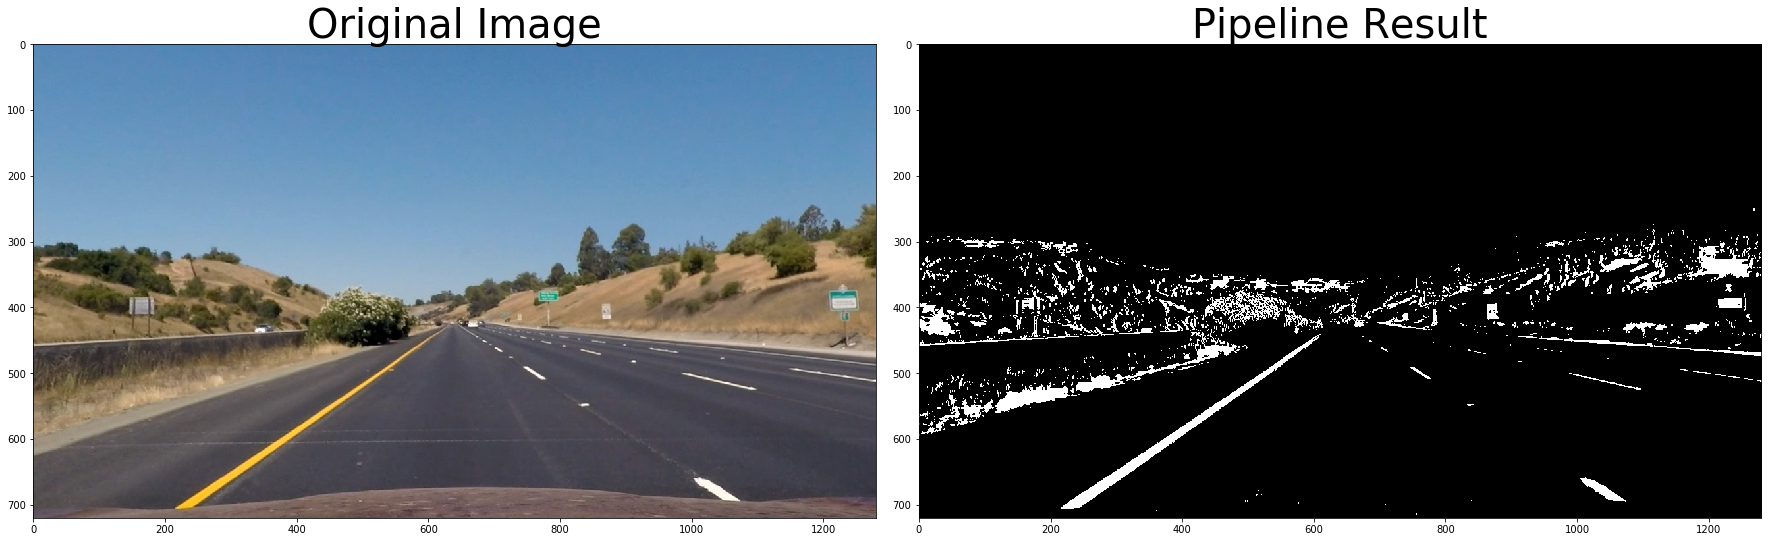

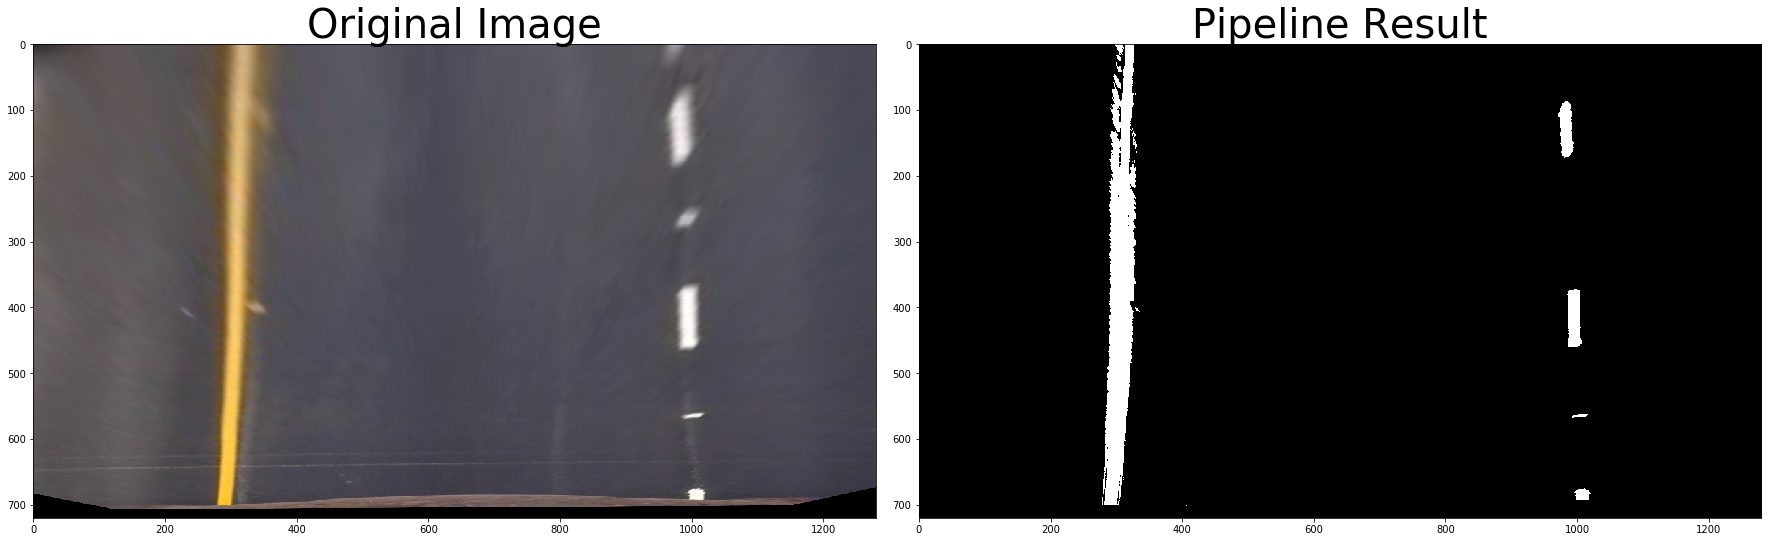

In [22]:
result = score_pixels(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = score_pixels(tr_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tr_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

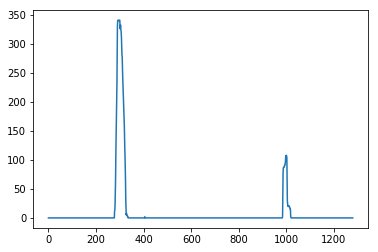

In [23]:
histogram = np.sum(result[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
binary_warped = result

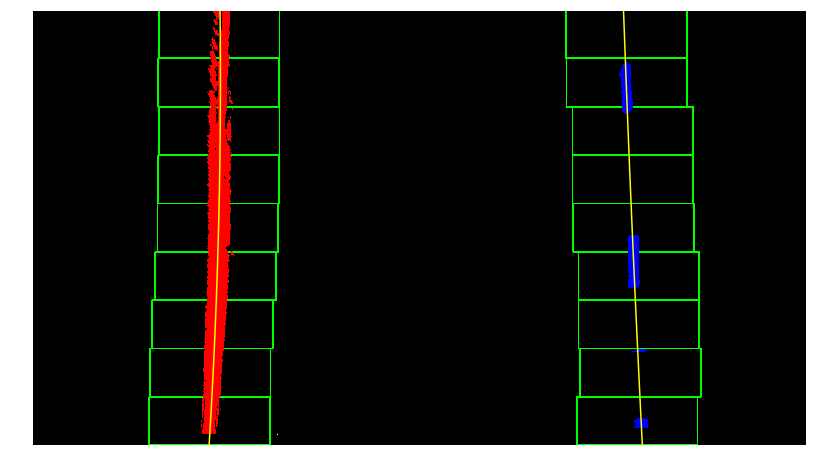

In [24]:
# left_fit, right_fit, l, r, d, la, ra, out_img = lane_lines(result, visualise=True)
left_fit, right_fit, l, r, d, la, ra, out_img = lane_lines(result, visualise = True)
left_fitx, right_fitx, ploty = fit_lanes(out_img, left_fit, right_fit)
plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

In [26]:
# left_fit, right_fit, l, r, d, la, ra = lane_lines2(result, left_fit, right_fit)
left_fit, right_fit,l, r, d, la, ra = lane_lines2(result, left_fit, right_fit)
left_fitx, right_fitx, ploty = fit_lanes(result, left_fit, right_fit)

(720, 0)

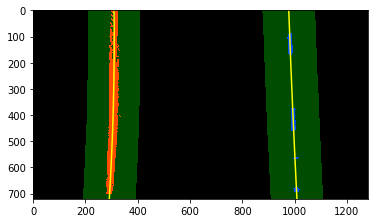

In [27]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((result, result, result))*255

nonzero = result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100
left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                               left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                     left_fit[1] * nonzeroy + left_fit[
                                                                         2] + margin)))

right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [41]:
def pipeline(img):
    global first
    global left_fit
    global right_fit
    global last_left
    global last_right
    global last_la 
    global right_la 
    global n
    obj_points, img_points = read_points()
    undist = cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = score_pixels(tr_img)
    if first:
        left_fit, right_fit, l, r, d, la, ra = lane_lines(binary_warped, visualise=False)
        first = False
    else:
        left_fit, right_fit, l, r, d, la, ra = lane_lines2(binary_warped, left_fit, right_fit)
    result = draw(binary_warped, img, inv_m, left_fit, right_fit, l, r, d, la, ra)
    return result

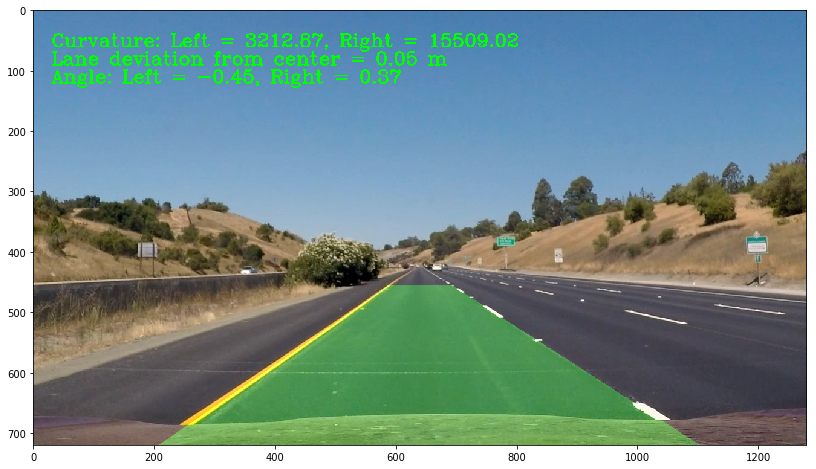

In [42]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
left_fit = [] 
right_fit = []
last_left= []
last_right = []
# !!!!!!!!!
last_la = [0]
last_ra = [0]
n = 5
first = True
result = pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

In [44]:

# check that parameters lie near mean
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # Left or Right line
        self.left = True
        # polynomial coefficients for the most recent fit
        self.current_fit = None
        # fit histovry over last n img
        self.history_fit = []
        # Last angle
        self.angle = None
        # Last curvature rad
        self.curve_rad = None
        # Best fit
        self.best_fit = None

    def lane_line_from_fit(self, binary_warped, fit):
        # Assume you now have a new warped binary image
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (fit[0] * (nonzeroy ** 2) + fit[1] * nonzeroy +
                                  fit[2] - margin)) & (nonzerox < (fit[0] * (nonzeroy ** 2) +
                                                                   fit[1] * nonzeroy + fit[
                                                                       2] + margin)))
        # Again, extract left and right line pixel positions
        leftx = nonzerox[lane_inds]
        lefty = nonzeroy[lane_inds]
        # Fit a second order polynomial to each
        return np.polyfit(lefty, leftx, 2)

    def lane_line(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        if self.left:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0] / nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                         (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]
        # Fit a second order polynomial to each
        return np.polyfit(y, x, 2)

    def fit_lane(self, warped, fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
        fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]
        return fitx, ploty

    def geometry(self, leftx, lefty, binary_warped):
        image_size = binary_warped.shape
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        # Calculate the new radius of curvature
        curve_rad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        # Now our radius of curvature is in meters
        # Example values: 632.1 m    626.2 m
        # Calculate Lane Deviation from center of lane:
        # First we calculate the intercept points at the bottom of our image, then use those to
        # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
        scene_height = image_size[0] * ym_per_pix
        scene_width = image_size[1] * xm_per_pix
        # Calculate angle of
        angle = m.atan(2 * left_fit_cr[0] * scene_height + left_fit_cr[1]) * 180 / m.pi
        return curve_rad, angle

    def calculate(self, binary_warped):
        try:
            if (not self.detected):
                fit = self.lane_line(binary_warped)
            else:
                # Get get line from previous fit
                fit = self.lane_line_from_fit(binary_warped, self.current_fit)
        except TypeError:
            fit = [1, 1, 1] 
        if self.current_fit is None:
            self.current_fit = fit
        # Get line pixels for drawing
        fitx, ploty = self.fit_lane(binary_warped, fit)
        # get geometry
        curve_rad, angle = self.geometry(fitx, ploty, binary_warped)
        # Sanity check, lines must be parallel
        if self.angle is not None and m.fabs(self.angle - angle) < 0.5:
            self.current_fit = fit
        else:
            self.detected = False
        self.angle = angle
        self.curve_rad = curve_rad
        # If history queue has max length, pop first entered(last seen image)
        if (len(self.history_fit) == 15):
            self.history_fit.pop()
        self.history_fit.insert(0, self.current_fit)
        self.best_fit = np.mean(self.history_fit, axis=0)


def draw2(warped, undist, Minv, left, right):
    # Draw lanes on scene
    left_fitx, right_fitx, ploty = fit_lanes(warped, left.best_fit, right.best_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    curvature_text = "Curvature: Left = " + str(np.round(left.curve_rad, 2)) + ", Right = " + str(np.round(right.curve_rad, 2))
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0, 255, 0), 2)
    #TODO: add deviation from center
    deviation_text = "Lane deviation from center = {:.2f} m".format(0)
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0, 255, 0), 2)
    angle_text = "Angle: Left = " + str(np.round(left.angle, 2)) + ", Right = " + str(np.round(right.angle, 2))
    cv2.putText(result, angle_text, (30, 120), font, 1, (0, 255, 0), 2)
    return result

def pipeline2(img):
    global left_line
    global right_line
    obj_points, img_points = read_points()
    undist = cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = score_pixels(tr_img)
    left_line.calculate(binary_warped)
    right_line.calculate(binary_warped)
    result = draw2(binary_warped, img, inv_m, left_line, right_line)
    return result

In [30]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
# clear lines
left_line = Line() 
right_line = Line()
right_line.left=False
clip1_output = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [45]:
video_challenge_output = "output_images/challenge_video_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
# clear lines
left_line = Line() 
right_line = Line()
right_line.left=False
clip1_output = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4



100%|█████████▉| 484/485 [04:37<00:00,  1.77it/s]WARNING:py.warnings:/Users/larionbabych/anaconda/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [04:38<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_output.mp4 

CPU times: user 5min 24s, sys: 7.97 s, total: 5min 32s
Wall time: 4min 38s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))